In [2]:
import os
import numpy as np
import pandas as po
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

In [3]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [5]:
from customLSTM import baseLSTM
from trainer import train
#from tester import test

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device - {}'.format(device))

Using device - cpu


In [10]:
raw_data = po.read_csv('data/cleaned_data.csv')
raw_data.head()

,0
0,0.098453
1,0.122610
2,0.125399
3,0.067789
4,-0.141216


In [11]:
prev_week = raw_data.shift(7)
prev_week.columns = ['1']

In [13]:
data = po.concat([raw_data, prev_week], axis = 1)
data = data[7:].reset_index(drop = True) #since there is no prev_week data for the first 7 days, I have discarded those rows
data.head()

,0,1
0,-0.096574,0.098453
1,-0.068217,0.122610
2,-0.005028,0.125399
3,0.064886,0.067789
4,0.117161,-0.141216


In [15]:
test_df = monthly_data.drop('Energy', axis = 1)[334:].reset_index(drop = True)
test_target = monthly_data['Energy'][334:].reset_index(drop = True)

In [21]:
input_dim = 11 #number of predictor variables (i.e. number of columns in train_df)
num_output_cols = 1 #number of values to be predicted at each timestep
hidden_dim = 100 #hidden dimension of the LSTM
num_epochs =  5 
window_size = 30 #sequence length for the LSTM (I have taken this to be 30 intutitively. In general this will be a parameter which will be tuned)
dropout_prob = 0 
batch_size = 100

In [22]:
#making a DataLoader object
train_data = TensorDataset(torch.tensor(train_df.to_numpy(), dtype = torch.float), torch.tensor(train_target.to_numpy(), dtype = torch.float))
train_dataloader = DataLoader(train_data, batch_size = batch_size)

In [23]:
model_1 = baseLSTM(input_dim, hidden_dim, num_output_cols, window_size, dropout_prob)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model_1.parameters(), lr=0.01)

In [24]:
#model_1.cuda() #Uncomment if GPU available

In [25]:
model_1, hidden_state, cell_state, losses = train(train_dataloader, window_size, model_1, loss_function, optimizer, num_epochs, input_dim, hidden_dim, dropout_prob)

Training epoch 1
Loss after 1 epochs = 2.005175828933716
Training epoch 2
Loss after 2 epochs = 0.6383031010627747
Training epoch 3
Loss after 3 epochs = 0.1836230307817459
Training epoch 4
Loss after 4 epochs = 0.027429617941379547
Training epoch 5
Loss after 5 epochs = 0.0007514404715038836


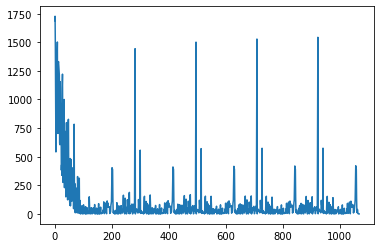

In [26]:
plt.plot(losses)

In [27]:
#Predicting Values for test set
window_size =  5 #setting different sequence length for testing
test_df_with_window_train = po.concat([train_df[-window_size:], test_df], axis = 0).reset_index(drop = True)
predictions_df = po.DataFrame()
actual_values = []
predictions = []

for i in tqdm_notebook(range(len(test_df))):
    input_ = torch.tensor((test_df_with_window_train[i:i+window_size]).to_numpy(), dtype = torch.float).view(window_size, 1, input_dim)

    prediction, (hidden_state, cell_state) = model_1(input_, hidden_state, cell_state)
    prediction = prediction.view(1).to(device) 
    
    actual_values.append(test_target[i])
    predictions.append(prediction.item())

predictions_df['Actual Values'] = actual_values
predictions_df['Predictions'] = predictions    

print('MAE = {}'.format(mean_squared_error(predictions_df['Actual Values'], predictions_df['Predictions'])))


MAE = 19.755027517936302


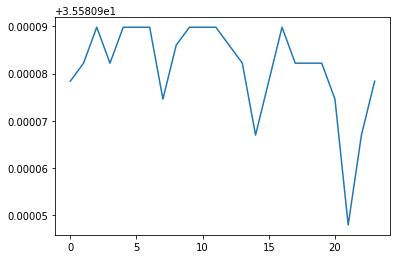

In [28]:
plt.plot(predictions_df['Predictions'])

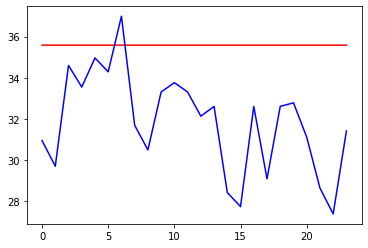

In [29]:
plt.plot(predictions_df['Predictions'], color = 'red')
plt.plot(predictions_df['Actual Values'], color = 'blue')

In [30]:
predictions_df

,Actual Values,Predictions
0,30.947612,35.580978
1,29.697728,35.580982
2,34.596198,35.580990
3,33.545665,35.580982
4,34.960593,35.580990
5,34.285582,35.580990
6,36.986555,35.580990
7,31.688456,35.580975
8,30.490496,35.580986
9,33.309226,35.580990
